# Michał Matak - Modele Bayesowskie do mapowania położenia obiektu



## Importowanie bibliotek
* numpy - operacje na macierzach 
* statistics - wyznaczenie średniej i wariancji
* matplotlib - tworzenie wykresów
* itertools - tworzenie wszytkich kombinacji dwu-elementowych zbioru
* math - funkcje matematyczne oraz stałe

In [1]:
import numpy as np
import statistics as stat
from matplotlib import pyplot as plt
from itertools import combinations
from math import exp, sqrt, pi, inf
from data_operations import get_data, split_into_classes, split_into_sets, get_dictionary_axes
from data_operations import test, create_heatmap, create_classification_heatmap, calculate_precision, calculate_recall, create_class_heatmap
import csv

In [2]:
def encode(number, data_dictionary):
    return number

def decode(number):
    return number

In [3]:
data, data_dictionary = get_data("series2", encode)

In [4]:
def get_feature(data, feature, object_class=None):
    return [record[0][feature] for record in data if not object_class or (record[1] == object_class)]

## Funkcje związane z klasyfikatorem Bayesowskim

Wyliczanie wartości rozkładu normalnego dla podanej średniej i odchylenia standardowego:

In [5]:
def gauss(x, mean, std_deviation):
    numerator = exp(-((x - mean)**2)/(2*std_deviation**2))
    denominator = std_deviation * sqrt(2*pi)
    return numerator/denominator

Zwrócenie parametrów modelu dla danego atrybutu i wszystkich klas w formie listy:

In [6]:
def train_parameters(data, feature):
    data_list = []
    for element in data_dictionary.values():
        temporary_list = get_feature(data, feature, element)
        data_list.append([stat.mean(temporary_list), stat.stdev(temporary_list)])
    return data_list

## Funkcja classify

Funkcja **classify**, jako argument przyjmuje element ze zbioru danych, zbiór danych, a także dwie liczby określające zgodnie według jakich atrybutów klasyfikować element. Wskazywana jest taka klasa $y$ dla której wartość wyrażenia:
<center>$P(x_i|y)\cdot P(x_j|y)\cdot P(y)$</center>
jest największa.  

Wartości $P(x_i|y)$ i $P(x_j|y)$ są obliczane na podstawie rozkładu Gaussa, którego parametry dla każdej klasy obliczane są przez funkcję *train_parameters* . Wartość $P(y)$ jest obliczana w specyficzny sposób, gdyż jest to długość listy wartości jakiegoś atrybutu dla klasy $y$ podzielona przez tą długość dla wszystkich klas.

In [7]:
def train(data):
    return [train_parameters(data, 0), train_parameters(data, 1), train_parameters(data, 2)]

In [8]:
def predict(element, train_par):
    parameters1, parameters2, parameters3 = train_par
    maximum = -inf
    object_class = -inf
    for i in range(len(data_dictionary)):
        value = gauss(element[0], *parameters1[i]) * gauss(element[1], *parameters2[i])* gauss(element[2], *parameters3[i])*(len(data)/len(get_feature(data, 0, i+1)))
        if (value > maximum): 
            object_class = i
            maximum = value
    return object_class + 1

## Ewaluacja - sprawdzenie działania algorytmu

Poniżej znajduje się funkcja, który sprawdza stopień poprawnośći przewidywań przez naiwny klasyfikator Bayesowski. Jako parametry przyjmuje zbiór testowy, treningowy oraz liczby określające atrybuty. W zbiorze testowym na pierwszym miejscu każdego elementu jest liczba oznaczająca klasę, która jest porównywana ze wskazaniem modelu. Jeśli model się pomylił dodawana jest jedynka do liczby błędów.

In [9]:
def evaluate(test_set, train_set):
    errors = 0
    train_par = train(train_set)
    for element in test_set:
        if (element[1] != predict(element, train_par)): errors += 1
    return errors/(len(train_set))

## Działanie programu

In [11]:
train_set, test_set = split_into_sets(0.75, data)
train_par = train(train_set)
class_vector = split_into_classes(train_set, data_dictionary, decode)


In [12]:
classification_array = test(class_vector, predict, [train_par])

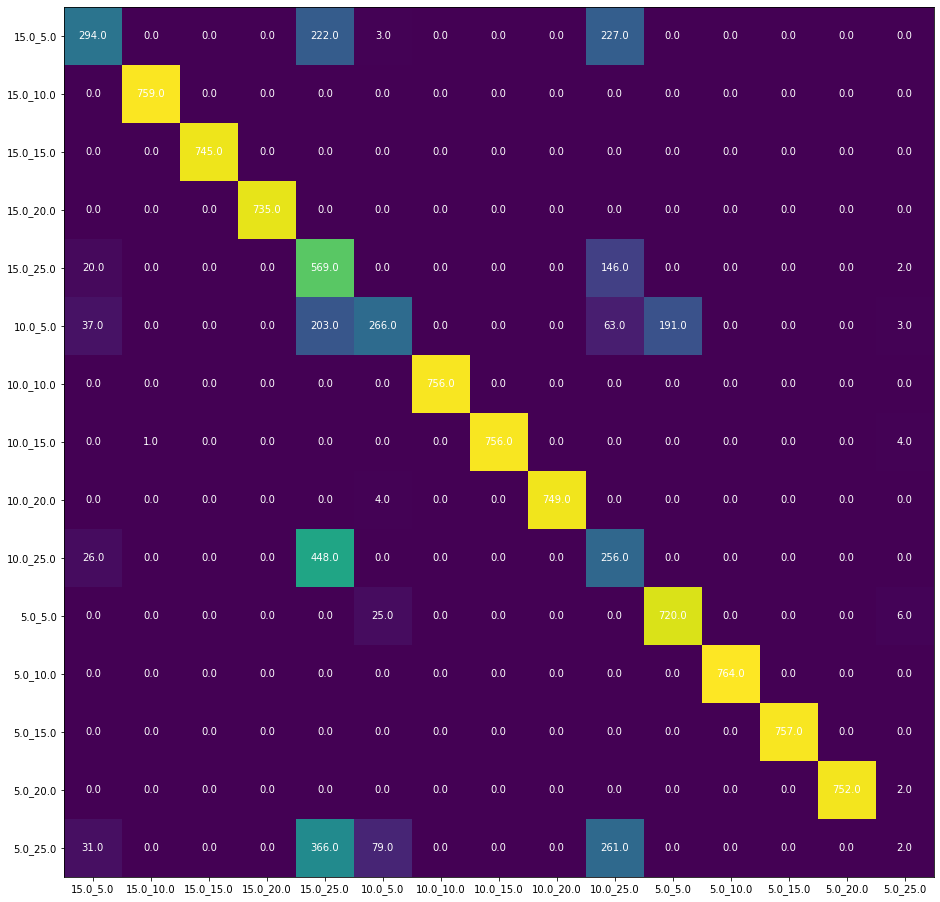

In [13]:
create_classification_heatmap(classification_array, data_dictionary)

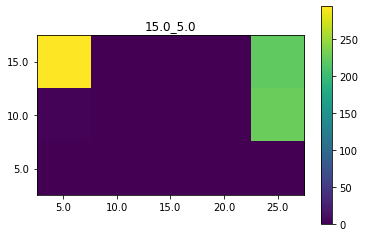

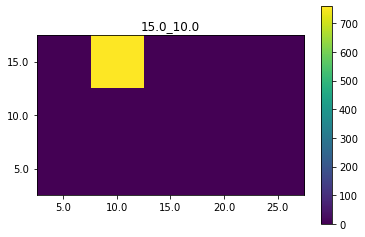

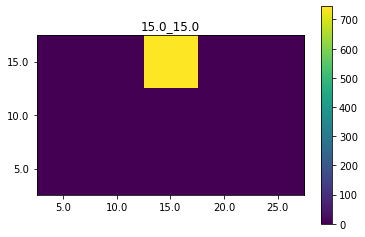

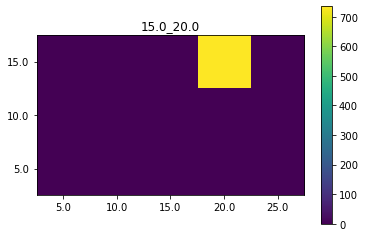

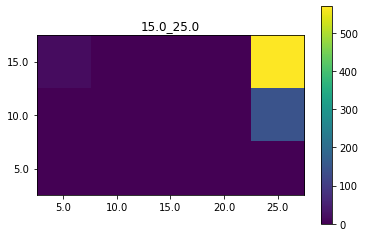

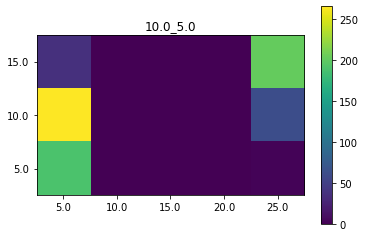

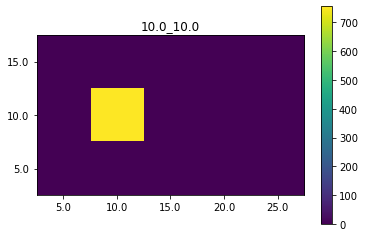

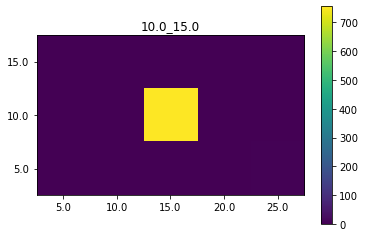

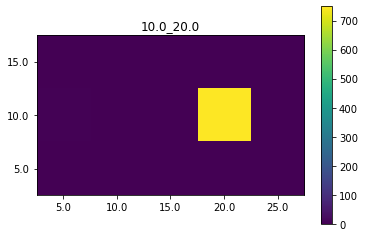

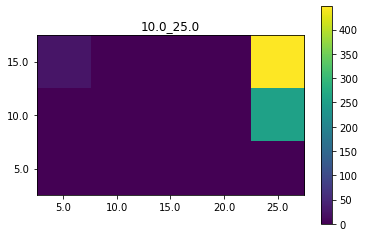

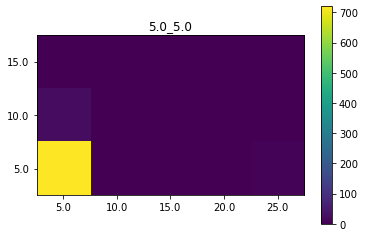

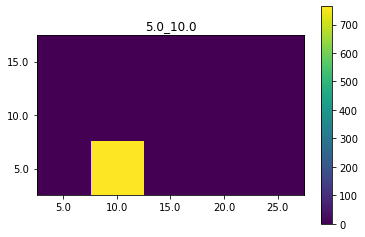

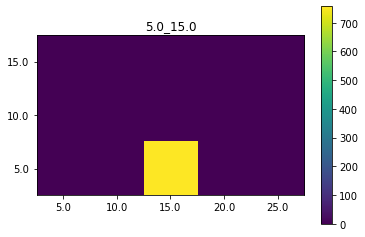

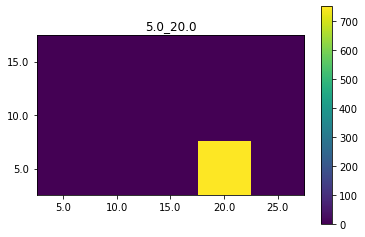

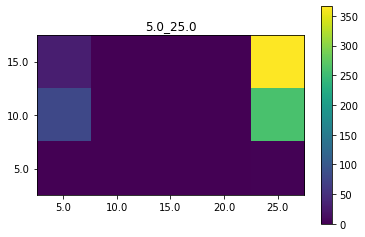

In [14]:
for class_name in data_dictionary:
    create_class_heatmap(class_name, data_dictionary, classification_array)


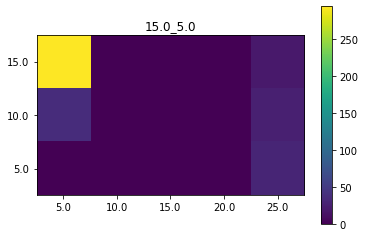

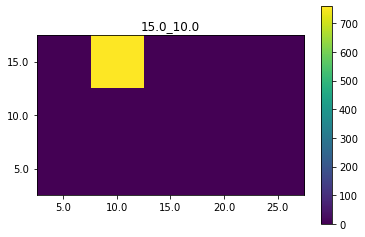

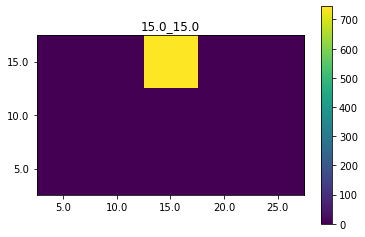

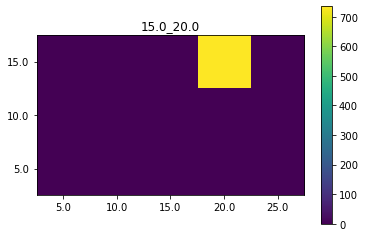

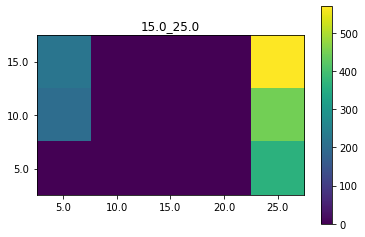

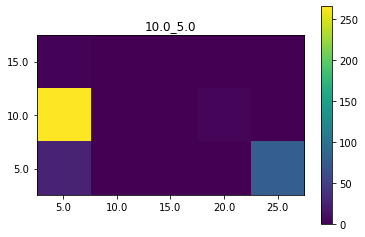

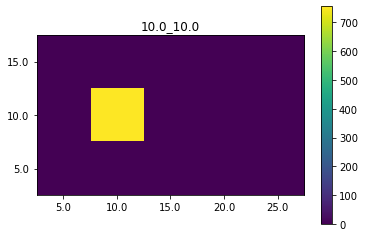

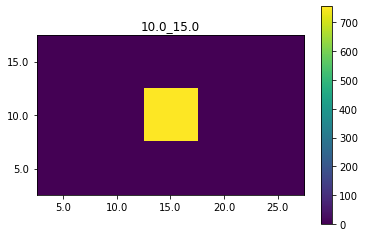

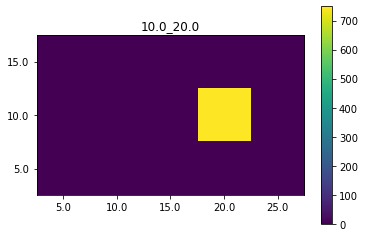

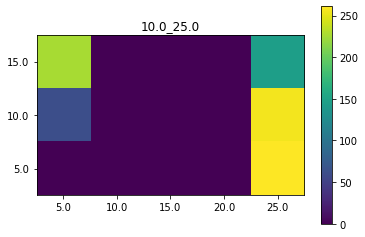

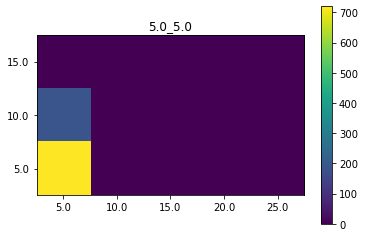

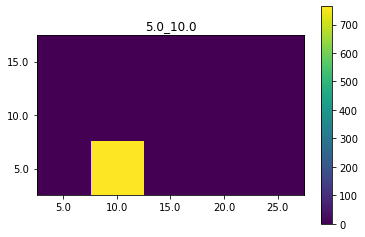

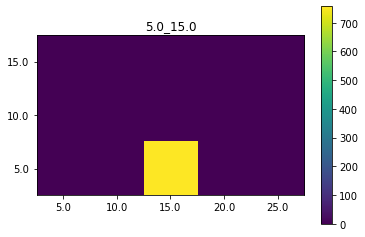

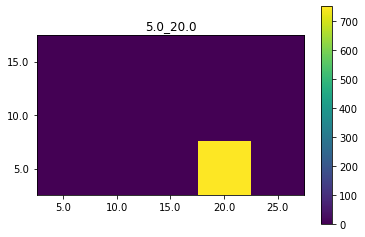

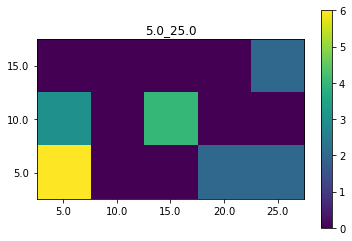

In [15]:
for class_name in data_dictionary:
    create_class_heatmap(class_name, data_dictionary, classification_array, True)

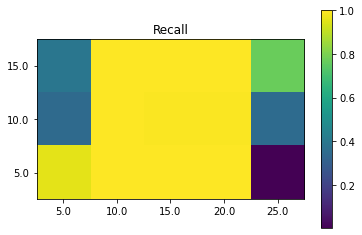

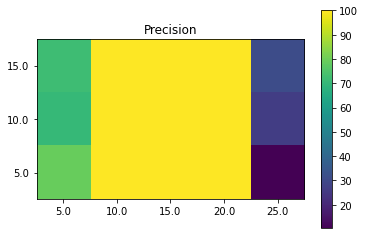

In [16]:
create_heatmap("Recall", data_dictionary, calculate_recall(classification_array))
create_heatmap("Precision", data_dictionary, calculate_precision(classification_array))

In [13]:
error_rate = evaluate(test_set, train_set)
print(error_rate)
print(f"Accuracy: {(1-error_rate)*100:.02f}%")

0.07706666666666667
Accuracy: 92.29%


## k-krotna walidacja

Podział danych na $k$ zbiorów do walidacji. Wynikiem działania jest lista o $k$ elementach [zbiór testowy], [zbiór treningowy]. Zbiory testowe liczą $\lfloor n/k \rfloor$ elementów z wyjątkiem ostatniego, który liczy $n - (k-1)\lfloor n/k \rfloor$. W szczególności gdy $n$ jest podzielne przez $k$, to zwrócone zostaje $k$ równych zbiorów. Wraz zbiorem, w liście zwracane jest jego dopełnienie.

In [29]:
def k_split(array, k):
    sets = []
    np.random.shuffle(array)
    set_length = int(len(array)/k)
    for i in range(k-1):
        sets.append([array[i*set_length:(i+1)*set_length], array[:i*set_length]+array[(i+1)*set_length:]])
    sets.append([array[(k-1)*set_length:], array[:(k-1)*set_length]])
    return sets

Uzyskanie ze zbioru danych listy opisującej wartości danego atrybutu, dla danej klasy (jeśli klasa nie jest podana, zwracana jest lista z całego zbioru)

We wcześniejszym fragmencie liczby 11 i 12 oznaczające 12 i 13 atrybut zostały wybrane nieprzypadkowo. Została przeprowadzana walidacja krzyżowa, która sprawdziła dla jakiej pary atrybutów zostaną osiągnięte najlepsze wyniki. Funkcja ją realizujące przyjmuje jako argument zbiór danych oraz parametr $k$.

In [36]:
def k_cross_validation(k, data):
    valid_sets = k_split(data, k)
    error_rate = 0
    for train_test in valid_sets:
        error_rate += evaluate(train_test[0], train_test[1])
    accuracy = 1 - error_rate/k
    print(f"Average accuracy: {100*accuracy:.2f}%")


In [37]:
k_cross_validation(4, data)

Average accuracy: 98.85%


In [65]:
train_set, test_set = split_into_sets(0.75, data)
train_par = train(train_set)

In [66]:
# class_vector with test
class_vector = split_into_classes(train_set, data_dictionary, decode)
for i in range(len(class_vector)):
    for element in class_vector[i]:
        if (element[1] != i+1): raise Exception()
    print(len(class_vector[i]))

746
736
766
773
771
741
742
747
751
740
732
731
750
765
759


## Rozkład prawdopodobieństwa dla atrybutów - wykresy

W realizacji założono, że rozkład wartości dla atrybutu może być opisany za pomocą rozkładu normalnego aby mozna było policzyć wartość $P(x_i|y)$ gdy $x_i$ nie przyjmuje wartości dyskretnych.

Poniżej zdefiniowana została pomocnicza funkcja, która pozwala na stworzenie wykresu pokazującego rozkład dla wartości podanego jako parametr atrybutu i funkcję rozkładu normalnego utworzoną z tych danych.

In [70]:
colors = [(np.random.choice(range(256), size=3)/255) for _ in range (len(data_dictionary))]

In [71]:
def plot_feature(data, feature):
    nbins = 10
    transparency = 0.5
    for element in data_dictionary:
        flist = get_feature(data, feature, data_dictionary[element])
        r, g, b = colors[data_dictionary[element]-1]
        plt.hist(flist, bins=nbins, density=True, fc=(r, g, b, transparency), label="Klasa " + str(data_dictionary[element]) + " - " + element)
        idx = np.linspace(*plt.xlim(), 100)
        val = [gauss(x, stat.mean(flist), stat.stdev(flist)) for x in idx]
#         print(stat.mean(flist), stat.stdev(flist))
        plt.plot(idx, val, color=(r, g, b, 1), label="Klasa " + str(data_dictionary[element]) + " - " + element)
    plt.title(f"Wykres dla atrybutu o indeksie {feature}")
    plt.legend()
    plt.show()

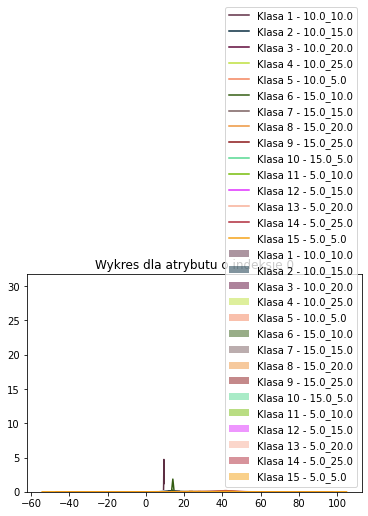

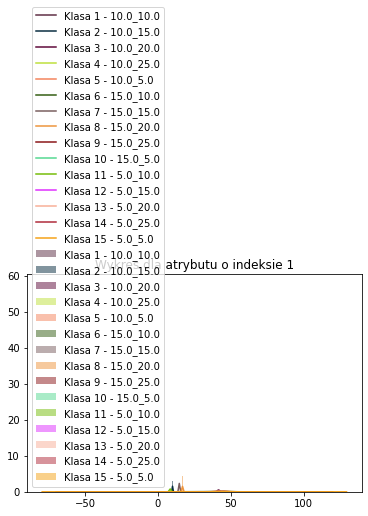

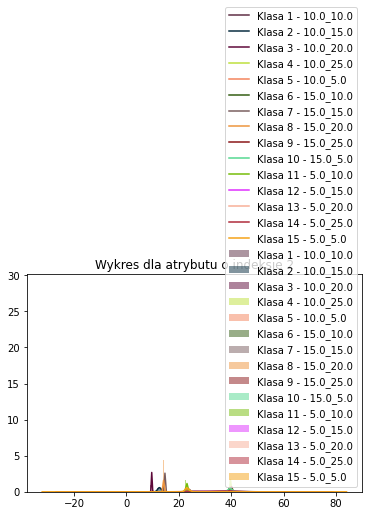

In [72]:
for i in range(3):
    plot_feature(data,i)

Jak widać na wykresach w większości przypadków rozkład $x_i$ możemy przybliżyć rozkładem normalnym.